## Conseguir datos

In [8]:
import os
import numpy as np
import random
import xml.etree.ElementTree as etree
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.feature import hog

In [9]:
#Parsetja el fitxer xml i recupera la informació necessaria per trobar la cara de l'animal
#
def extract_xml_annotation(filename):
    """Parse the xml file
    :param filename: str
    :return annotation: diccionari
    """
    z = etree.parse(filename)
    objects = z.findall('./object')
    size = (int(float(z.find('.//width').text)), int(float(z.find('.//height').text)))
    dds = []
    for obj in objects:
        dds.append(obj.find('name').text)
        dds.append([int(float(obj.find('bndbox/xmin').text)),
                                      int(float(obj.find('bndbox/ymin').text)),
                                      int(float(obj.find('bndbox/xmax').text)),
                                      int(float(obj.find('bndbox/ymax').text))])

    return {'size': size, 'informacio': dds}

In [10]:
# Selecciona la cara de l'animal i la transforma a la mida indicat al paràmetre mida_desti
def retall_normalitzat(imatge, dades, mida_desti=(64,64)):
    """
    Extreu la regió de la cara (ROI) i retorna una nova imatge de la mida_destí
    :param imatge: imatge que conté un animal
    :param dades: diccionari extret del xml
    :mida_desti: tupla que conté la mida que obtindrà la cara de l'animal
    """
    x, y, ample, alt = dades['informacio'][1]
    retall = np.copy(imatge[y:alt, x:ample])
    return resize(retall, mida_desti)

In [11]:
def obtenir_dades(carpeta_imatges, carpeta_anotacions, mida=(64, 64)):
    """Genera la col·lecció de cares d'animals i les corresponents etiquetes
    :param carpeta_imatges: string amb el path a la carpeta d'imatges
    :param carpeta_anotacions: string amb el path a la carpeta d'anotacions
    :param mida: tupla que conté la mida que obtindrà la cara de l'animal
    :return:
        images: numpy array 3D amb la col·lecció de cares
        etiquetes: llista binaria 0 si l'animal és un moix 1 en cas contrari
    """

    imatges_elements = [entry for entry in os.listdir(carpeta_imatges) 
                    if os.path.isfile(os.path.join(carpeta_imatges, entry)) 
                    and entry.lower().endswith('.png')]
    
    n_elements = len(imatges_elements)
    # Una matriu 3D: mida x mida x nombre d'imatges
    imatges = np.zeros((mida[0], mida[1], n_elements), dtype=np.float16)
    # Una llista d'etiquetes
    etiquetes = [0] * n_elements

    #  Recorre els elements de les dues carpetes: llegeix una imatge i obté la informació interessant del xml
    for idx, element in enumerate(imatges_elements):
        nom = element.split(".")
        nom_fitxer = nom[0] + ".xml"

        path_anotacio = os.path.join(carpeta_anotacions, nom_fitxer)
        imatge_path = os.path.join(carpeta_imatges, element)
        imatge = imread(imatge_path, as_gray=True)
        anotacions = extract_xml_annotation(path_anotacio)
        
        cara_animal = retall_normalitzat(imatge, anotacions, mida)
        tipus_animal = anotacions["informacio"][0]
        
        imatges[:, :, idx] = cara_animal
        etiquetes[idx] = 0 if tipus_animal == "cat" else 1

    return imatges, etiquetes

In [16]:
def showHoGVariations(imatge, hogParams):
    fig, axes = plt.subplots(1, len(hogParams)+1, figsize=(15, 15))

    axes[0].imshow(imatge, cmap='gray')
    axes[0].axis('off')
    
    for idx, params in enumerate(hogParams):
        #print(f"HoG Params {params}")
    
        caract, imatge_hog = hog(imatges_1[:, :, randomIdx],
                                 orientations=params[1],
                                 pixels_per_cell=params[0],
                                 cells_per_block=params[2],
                                 block_norm='L2-Hys',
                                 visualize=True,
                                 transform_sqrt=True)

        axes[idx+1].imshow(imatge_hog, cmap='gray')
        axes[idx+1].set_title(f"{caract.shape} {params}")
        axes[idx+1].axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
def obtenirHoG(imatges):

    pixels_bloc = (8, 8)
    orientacions = 8
    blocs = (2, 2)

    descriptors = []
    imatges_hog = []

    for idx in range(imatges.shape[2]):

        imatge = imatges[:, :, idx]
        descriptor, imatge = hog(imatge,
                                 orientations=orientacions,
                                 pixels_per_cell=pixels_bloc,
                                 cells_per_block=blocs,
                                 block_norm='L2-Hys',
                                 visualize=True,
                                 transform_sqrt=True)
        
        descriptors.append(descriptor)
        imatges_hog.append(imatge)

    descriptors = np.array(descriptors)   
    imatges_hog = np.array(imatges_hog)
    
    return descriptors, imatges_hog

In [14]:
carpeta_images_1 = "gatigos/images_200"  # NO ES POT MODIFICAR
carpeta_anotacions_1 = "gatigos/annotations_200"  # NO ES POT MODIFICAR
mida = (128, 128)  # DEFINEIX LA MIDA, ES RECOMANA COMENÇAR AMB 64x64
imatges_1, etiquetes_1 = obtenir_dades(carpeta_images_1, carpeta_anotacions_1, mida)

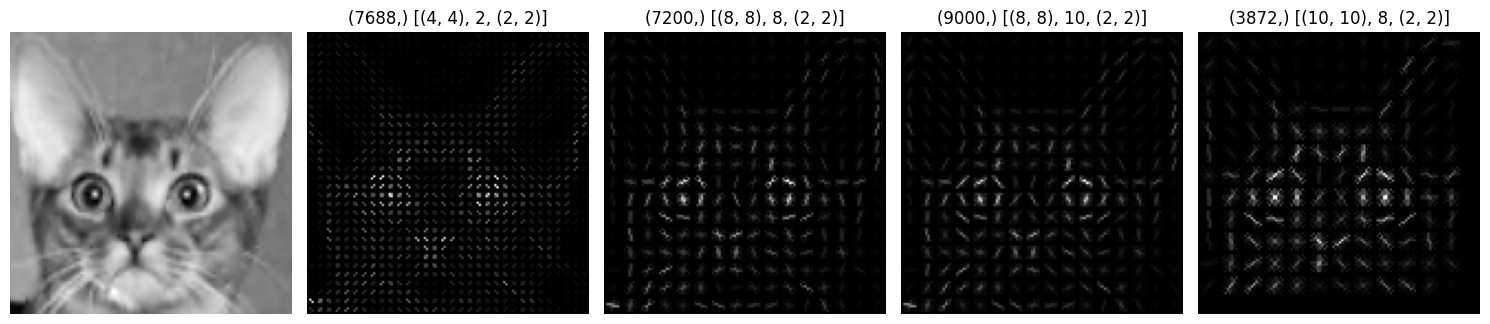

In [58]:
randomIdx = random.randint(0,len(imatges_1)-1)
params = [[(4, 4), 2, (2, 2)], 
          [(8, 8), 8, (2, 2)],
          [(8, 8), 10, (2, 2)], 
          [(10, 10), 8, (2, 2)]]

showHoGVariations(imatges_1[:, :, randomIdx], params)

In [18]:
caracteristiques_1, imatges_hog_1 = obtenirHoG(imatges_1)

In [21]:
# guardar las características generadas
# format: saves/midaImatges_pixelsBloc_orientacions_blocs_nImatges/idx.npz

# 1 = guardar | 2 = leer
accio = 0

saving_path = f'saves/{mida[0]}_8_8_2_{imatges_1.shape[2]}/001.npz'
print(saving_path)

if accio == 1:
    np.savez(saving_path, caract=caracteristiques_1, imgs_hog=imatges_hog_1)
elif accio == 2:
    dades = np.load(saving_path)
    caracteristiques_1 = dades['caract']
    imatges_hog_1 = dades['imgs_hog']

saves/128_8_8_2_200/001.npz


## Modelo de clasificación

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.spatial import distance_matrix
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV

In [23]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(caracteristiques_1, etiquetes_1, test_size=0.33, random_state=42)
imatges_train_1, imatges_test_1, imghog_train_1, imghog_test_1 = train_test_split(np.transpose(imatges_1, (2, 0, 1)), imatges_hog_1, test_size=0.33, random_state=42)

In [24]:
scaler = MinMaxScaler()  #StandardScaler()
X_transformed_1 = scaler.fit_transform(X_train_1)
X_test_transformed_1 = scaler.transform(X_test_1)

In [25]:
random_state = 33
kernels = ["linear", "rbf", "poly"]
parameters_set = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': ['scale', 'auto', 0.1, 0.01, 0.001]}

In [27]:
best_estimators = [{},{},{}]
precisions = [0,0,0]
recalls = [0,0,0]
f1s = [0,0,0]

for idx, kernel in enumerate(kernels):
    #svm = SVC(kernel=kernel, random_state=random_state)
    svm = SVC(kernel=kernel)
    clf = GridSearchCV(svm, parameters_set, cv=3)
    
    clf.fit(X_transformed_1, y_train_1)

    print(f"Millor model {kernel} amb:", clf.best_estimator_)
    best_estimators[idx] = clf.best_estimator_
    resultats = clf.best_estimator_.predict(X_test_transformed_1)
    
    precisions[idx] = precision_score(y_test_1, resultats)
    recalls[idx] = recall_score(y_test_1, resultats)
    f1s[idx] = f1_score(y_test_1, resultats)
    print(f"   Precisió: {precisions[idx]}")
    print(f"   Sensitivitat: {recalls[idx]}")
    print(f"   F1: {f1s[idx]}")

Millor model linear amb: SVC(C=0.01, kernel='linear')
   Precisió: 0.9090909090909091
   Sensitivitat: 0.8695652173913043
   F1: 0.8888888888888888
Millor model rbf amb: SVC(C=10)
   Precisió: 0.8823529411764706
   Sensitivitat: 0.9782608695652174
   F1: 0.9278350515463918
Millor model poly amb: SVC(C=0.01, gamma=0.1, kernel='poly')
   Precisió: 0.9130434782608695
   Sensitivitat: 0.9130434782608695
   F1: 0.9130434782608695


Imagen 0 real es 0


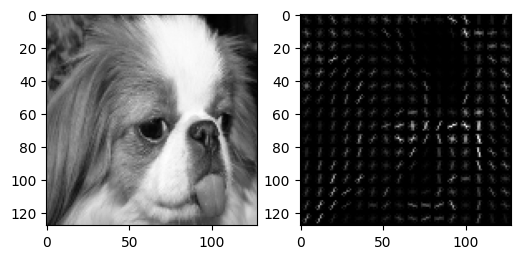

Imagen 1 real es 1


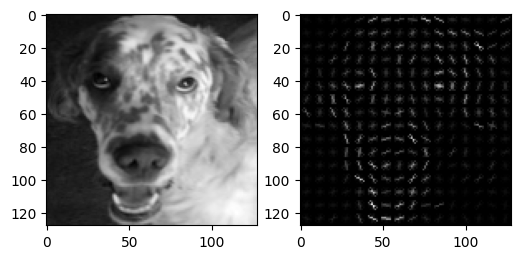

In [30]:
for i in range(2):
    fig, axes = plt.subplots(1, 2, figsize=(6, 6))
    
    print(f"Imagen {i} real es {y_test_1[i]}")
    axes[0].imshow(imatges_train_1[i,:,:], cmap='gray')
    axes[1].imshow(imghog_train_1[i,:,:], cmap='gray')
    plt.show()

## Test sencer

In [91]:
print(a)
print(b)
print(c)
print(d)
print()
print(c_train)
print(c_test)
print()
print(a_train)
print(a_test)
print()
print(d_train)
print(d_test)
print()
print(b_train)
print(b_test)

['a', 'b', 'c', 'd', 'e', 'f', 'g']
[1, 2, 3, 4, 5, 6, 7]
['a1', 'b2', 'c3', 'd4', 'e5', 'f6', 'g7']
[11, 22, 33, 44, 55, 66, 77]

['c3', 'e5', 'd4', 'g7']
['a1', 'b2', 'f6']

['c', 'e', 'd', 'g']
['a', 'b', 'f']

[33, 55, 44, 77]
[11, 22, 66]

[3, 5, 4, 7]
[1, 2, 6]


In [89]:
a = ['a','b','c','d','e','f','g']
b = [1,2,3,4,5,6,7]

c = ['a1','b2','c3','d4','e5','f6','g7']
d = [11,22,33,44,55,66,77]

c_train, c_test, b_train, b_test = train_test_split(c, b, test_size=0.33, random_state=42)
a_train, a_test, _, _ = train_test_split(a, b, test_size=0.33, random_state=42)
d_train, d_test, _, _ = train_test_split(d, b, test_size=0.33, random_state=42)

In [86]:
carpeta_images_2 = "gatigos/images"  # NO ES POT MODIFICAR
carpeta_anotacions_2 = "gatigos/annotations"  # NO ES POT MODIFICAR
imatges_2, etiquetes_2 = obtenir_dades(carpeta_images_2, carpeta_anotacions_2, mida)

caracteristiques_2, imatges_hog_2 = obtenirHoG(imatges_2)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(caracteristiques_2, etiquetes_2, test_size=0.33, random_state=42)
imatges_train_2, imatges_test_2, _, _ = train_test_split(np.transpose(imatges_2, (2, 0, 1)), etiquetes_2, test_size=0.33, random_state=42)
imghog_train_2, imghog_test_2, _, _ = train_test_split(imatges_hog_2, etiquetes_2, test_size=0.33, random_state=42)

X_transformed_2 = scaler.fit_transform(X_train_2)
X_test_transformed_2 = scaler.transform(X_test_2)

best_estimator = best_estimators[f1s.index(max(f1s))]

svc = SVC(**(best_estimator.get_params()))
svc.fit(X_transformed_2, y_train_2)
prediccio = svc.predict(X_test_transformed_2)

precisio = precision_score(y_test_2, prediccio)
recall = recall_score(y_test_2, prediccio)
f1 = f1_score(y_test_2, prediccio)
print(f"   Precisió: {precisio}")
print(f"   Sensitivitat: {recall}")
print(f"   F1: {f1}")

   Precisió: 0.9393939393939394
   Sensitivitat: 0.9544334975369458
   F1: 0.9468540012217471


In [84]:
print(imatges_2.shape)
print(len(etiquetes_2))
print()
print(caracteristiques_2.shape)
print(np.transpose(imatges_2, (2, 0, 1)).shape)
print(imatges_hog_2.shape)
print()
print(X_train_2.shape)
print(X_test_2.shape)
print(len(y_train_2))
print(len(y_test_2))
print()
print(imatges_train_2.shape)
print(imatges_test_2.shape)
print(imghog_train_2.shape)
print(imghog_test_2.shape)
print()
print(prediccio.shape)

(128, 128, 3686)

(3686, 7200)
3686
(3686, 128, 128)
(3686, 128, 128)

(2469, 7200)
(1217, 7200)
2469
1217

(2469, 128, 128)
(1217, 128, 128)
(2469, 128, 128)
(1217, 128, 128)

(1217,)


Real és ca | Predit és ca


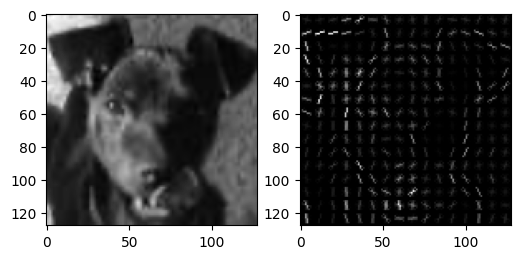

Real és ca | Predit és ca


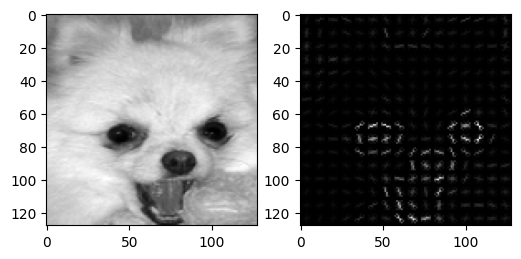

Real és ca | Predit és ca


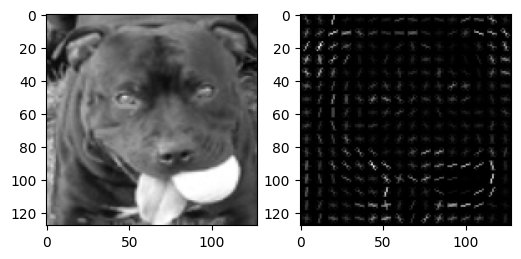

Real és moix | Predit és moix


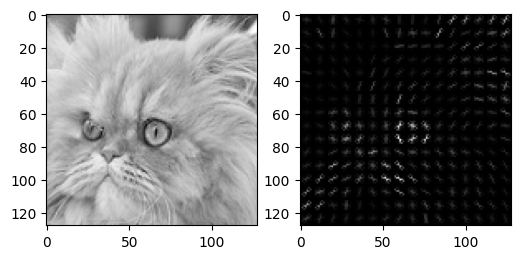

Real és moix | Predit és moix


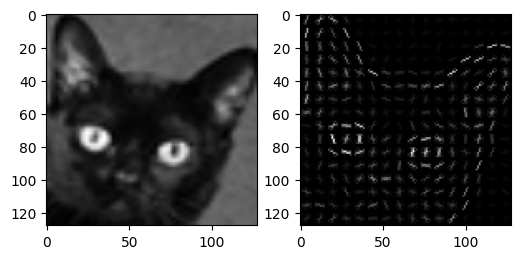

Real és ca | Predit és ca


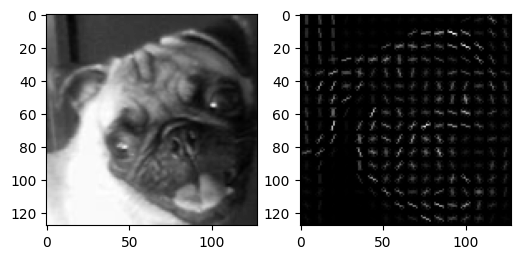

Real és ca | Predit és ca


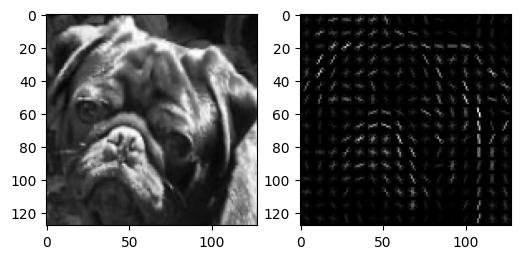

Real és ca | Predit és ca


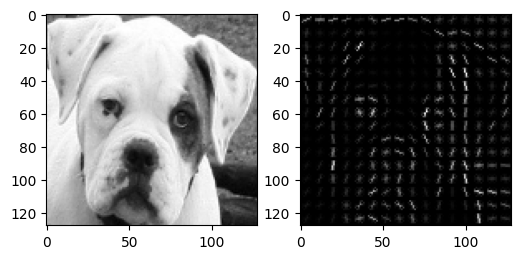

Real és moix | Predit és moix


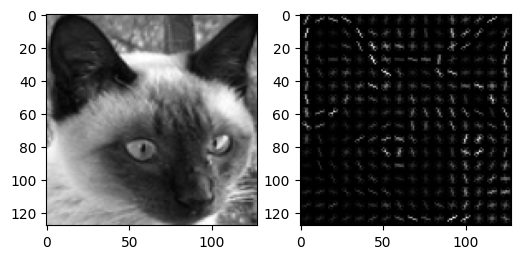

Real és ca | Predit és ca


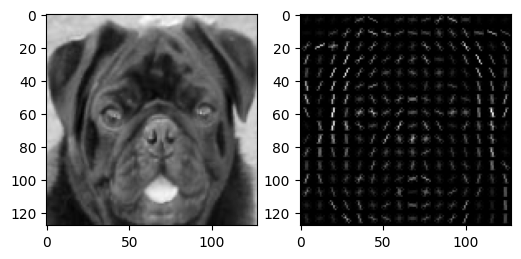

In [99]:
n_imatges = 10
randomIdx = random.randint(0,len(imatges_2)-n_imatges)

for i in range(randomIdx, randomIdx + n_imatges):
    fig, axes = plt.subplots(1, 2, figsize=(6, 6))
    
    print(f"Real és {'moix' if y_test_2[i] == 0 else 'ca'} | Predit és {'moix' if prediccio[i] == 0 else 'ca'}")
    axes[0].imshow(imatges_test_2[i,:,:], cmap='gray')
    axes[1].imshow(imghog_test_2[i,:,:], cmap='gray')
    plt.show()